In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
from bs4 import BeautifulSoup
import string
from transformers import BertTokenizer


In [2]:
label2id = {
    "Anger": 0,
    "Fear": 1,
    "Happy": 2,
    "Love": 3,
    "Sadness": 4
}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
data = pd.read_csv("dataset/train.csv") 
data['label'].value_counts()
test_data = pd.read_csv("dataset/test.csv")


In [4]:
model_name = "indobenchmark/indobert-lite-base-p2"
tokenizer = BertTokenizer.from_pretrained(model_name)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.


In [5]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [6]:
# Cell 5: Define functions for loading chat words and preprocessing text
def load_chat_words_dict(filepath):
    # Load the chat words dictionary from a CSV file
    df = pd.read_csv(filepath)
    chat_words_dict = dict(zip(df['slang'], df['formal']))
    return chat_words_dict

def preprocess_text(text, chat_words_dict):
    # Lower casing
    text = text.lower()
    
    # Removal of URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Removal of HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
        
    # Removal of emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    text = emoticon_pattern.sub(r'', text)



    # Split into words to apply chat words conversion
    words = text.split()
    # Replace chat words if they exist in the dictionary
    words = [chat_words_dict[word] if word in chat_words_dict else word for word in words]
    # Join the words back into a single string
    text = ' '.join(words)
    
    return text



In [7]:
chat_words_dict = load_chat_words_dict('colloquial-indonesian-lexicon.csv')
def preprocess_batch(example):
    example['text'] = preprocess_text(example['text'], chat_words_dict)
    return example

sample_text = "kutu msih hidup, :( sdh saya tes langsung. merasa ditipu nih, semoga dapat musibah dah lu :( ????"
processed_text = preprocess_text(sample_text, chat_words_dict)
print(sample_text)
print(processed_text)


kutu msih hidup, :( sdh saya tes langsung. merasa ditipu nih, semoga dapat musibah dah lu :( ????
kutu masih hidup, sudah saya tes langsung. merasa ditipu nih, semoga dapat musibah deh lu ????


In [8]:
def preprocess_batch(batch):
    batch['text'] = preprocess_text(batch['text'], chat_words_dict)
    return batch


In [9]:
dataset = Dataset.from_pandas(data)
test_dataset = Dataset.from_pandas(test_data)


In [10]:
processed_dataset = dataset.map(preprocess_batch)
processed_test_dataset = test_dataset.map(preprocess_batch)


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize the preprocessed dataset (using batched mapping)
tokenized_dataset = processed_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = processed_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [12]:
# Cell 10: Split the tokenized dataset into training and testing sets
train_dataset = tokenized_dataset
val_test = tokenized_test_dataset.train_test_split(test_size=0.5)
val_dataset = val_test['train']
test_dataset = val_test['test']                                                                                  

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(train_dataset[0])


Training set size: 1200
Validation set size: 150
Test set size: 150
{'text': 'barang asli nya tak seindah yang difoto', 'label': 4, 'input_ids': [2, 963, 2170, 1107, 368, 24561, 5636, 21, 34, 28941, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


In [14]:
# Cell 12: Define a compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    # Optionally, print a classification report
    # print(classification_report(labels, predictions))
    return {"accuracy": accuracy}


In [15]:
torch.cuda.empty_cache()
#seed 42 
torch.manual_seed(42)

In [16]:
# Cell 13: Define training arguments and initialize the Trainer
# Cell 11: Load the model with the correct number of output labels
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=3,
    save_strategy="epoch",
    torch_compile_backend="eager",
    torch_compile=True,
    load_best_model_at_end=True,
 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Cell 14: Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.125300,1.068079,0.493333
2,0.851900,0.922395,0.540000
3,0.658100,0.861007,0.613333
4,0.551200,0.835244,0.686667
5,0.517300,0.833217,0.686667


TrainOutput(global_step=250, training_loss=0.7942073185443879, metrics={'train_runtime': 48.3907, 'train_samples_per_second': 123.991, 'train_steps_per_second': 5.166, 'total_flos': 26556050197872.0, 'train_loss': 0.7942073185443879, 'epoch': 5.0})

In [18]:
# Cell 15: Evaluate the model on the test set and print results
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


Evaluation results: {'eval_loss': 0.8332173228263855, 'eval_accuracy': 0.6866666666666666, 'eval_runtime': 0.4951, 'eval_samples_per_second': 302.945, 'eval_steps_per_second': 38.373, 'epoch': 5.0}


In [25]:
# -------------------------
# 6. Predict and Evaluate
# -------------------------



preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(axis=-1)
val_acc = accuracy_score(test_dataset["label"], pred_labels)
print("Validation Accuracy:", val_acc)
print("Classification Report:")
print(classification_report(test_dataset["label"], pred_labels))


Validation Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        29
           1       0.60      0.60      0.60        30
           2       0.75      0.68      0.71        31
           3       0.69      0.77      0.73        26
           4       0.61      0.74      0.67        34

    accuracy                           0.67       150
   macro avg       0.68      0.67      0.67       150
weighted avg       0.67      0.67      0.67       150



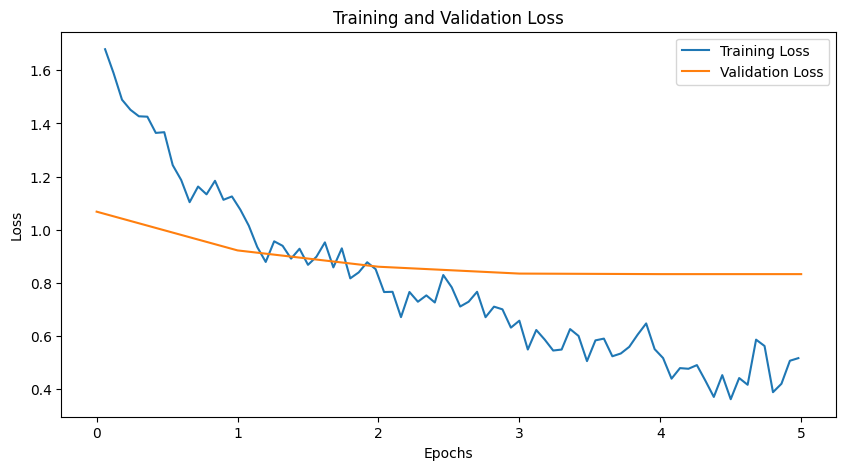

In [21]:
import matplotlib.pyplot as plt

# Extract loss and epoch information from the log history
log_history = trainer.state.log_history
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
epochs = [entry['epoch'] for entry in log_history if 'loss' in entry]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot([0,1,2,3,4,5], val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

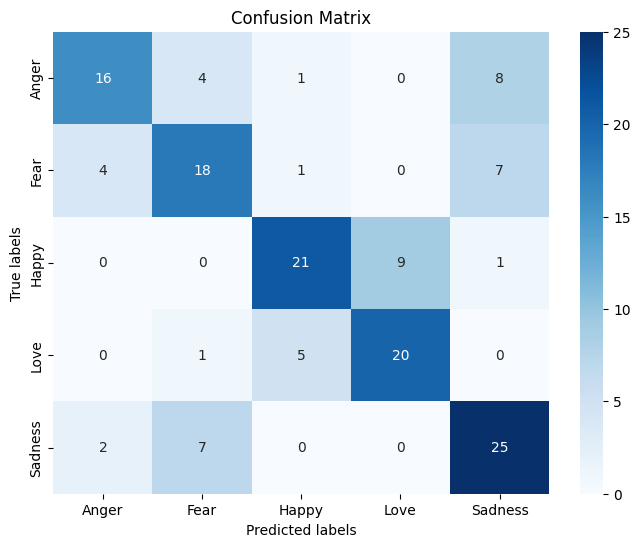

In [23]:
#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset["label"], pred_labels)
plt.figure(figsize=(8, 6))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [51]:
geminiPred = pd.read_csv("dataset/tebak.csv")

testData = pd.read_csv("dataset/test.csv")

#evaluate
print(classification_report(testData['label'], geminiPred['label']))
print(accuracy_score(testData['label'], geminiPred['label']))


              precision    recall  f1-score   support

           0       0.52      0.66      0.58        56
           1       0.77      0.15      0.25        66
           2       0.61      0.85      0.71        60
           3       0.80      0.47      0.59        60
           4       0.46      0.78      0.58        58

    accuracy                           0.57       300
   macro avg       0.63      0.58      0.54       300
weighted avg       0.64      0.57      0.54       300

0.57
